# Discrete Omega Metric Maximization 

This notebook will minimize the denominator of the discrete omega risk/return metric for portfolios. I will indirectly optimize the portfolio by minimizing the gradient of Lagrangian.

$$
    \min_{\vec{w}} \sum_{j} (\tau - \vec{w}^{T}r_j) \\
    s.t. \\
    \vec{w}^{T}1 - 1 = 0 \\
    \vec{|w|}^{T}1 - 1 = 0 \\
    \vec{w}^{T}\tilde{r} - \tau - c \geq 0
$$

Where $r_j$ a sample return of the of each asset within the portfolio. We use sample returns to circumvent the use of convolutions. $\tilde{r}$ is the vector of expected returns for each asset. The inequality constraint utilizes a constant $c$ to adjust the minimum expectation of our optimal portfolio. I will be manipulating $c$ to line search for the maximum $\Omega(\tau)$. $\tau$ is a constant that defines where losses begin. By setting $\tau =1$, I am defining losses to be returns with less than $1$.

$$
L(\vec{w}, \lambda_1, \lambda_2, \theta) = \sum_{j} (\tau - \vec{w}^{T}r_j) + \lambda_1 (\vec{w}^{T}1 - 1) + \lambda_2 (\vec{|w|}^{T}1 - 1) + \theta (\vec{w}^{T}\tilde{r} - \tau - c - s^2)
$$

Where $s$ is a slack variable that is solved for at each gradient descent step. The slack variable ensures that gradients only come to theta when the inequality constraint is broken during optimization.

$$
h(\vec{w}, \lambda_1, \lambda_2, \theta) = \frac{1}{2}[\sum_k (\frac{\partial L}{\partial w_k})^2 + (\frac{\partial L}{\partial \lambda_1})^2 + (\frac{\partial L}{\partial \lambda_2})^2 + (\frac{\partial L}{\partial \theta})^2]
$$

The notebook implements gradient descent to find the minimum of $h(.)$.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

#Risky Call Option
x1 = np.array([0.0, 0.5, 1.6, 2.0])
px1 = np.array([0.6, 0.3, 0.05, 0.05])

#Uniform Asset
x2 = np.array([0.0, 0.3, 1.5, 2.5])
px2 = np.array([0.25, 0.25, 0.25, 0.25])

#Biased Coin Flip Asset
x3 = np.array([0.0, 0.5, 1.5, 2.1])
px3 = np.array([0.5, 0.0, 0.0, 0.5])

#Shitty Asset 1
x4 = np.linspace(0, 1.3, num=50)
px4 = np.square(1.3 - x4)
px4 = px4/np.sum(px4)

#Shitty Asset 2
x5 = np.linspace(0.8, 1.2, num=50)
px5 = 1.0 - 25*np.square(x5 - 1.0)
px5 = px5/np.sum(px5)

#Shitty Asset 2
x6 = np.linspace(0.8, 1.2, num=50)
px6 = 1.0 - 25*np.square(x6 - 1.0)
px6 = px6/np.sum(px6)

x = [x1, x2, x3, x4, x5, x6]
px = [px1, px2, px3, px4, px5, px6]

Asset:  1


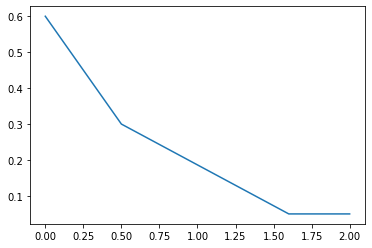

Asset:  2


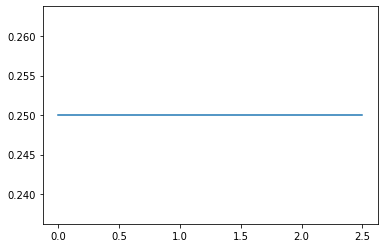

Asset:  3


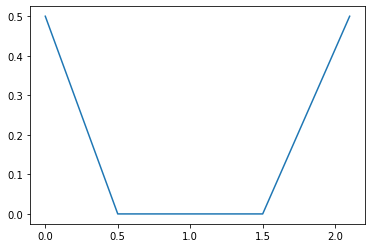

Asset:  4


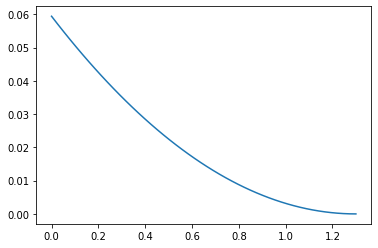

Asset:  5


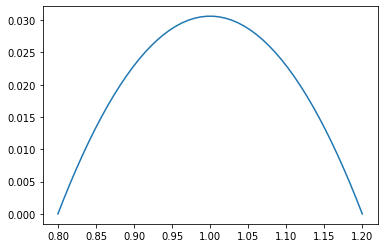

Asset:  6


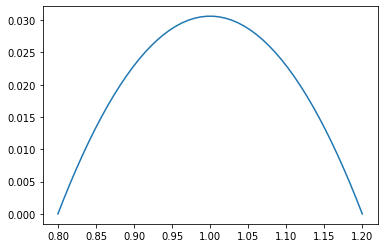

[0.33, 1.075, 1.05, 0.3151515151515152, 0.9999999999999998, 0.9999999999999998]


In [2]:
#precomputations
E = [] #expected values of each distr
for i in range(len(x)):
    E.append(np.dot(x[i], px[i]))
    print("Asset: ", i+1)
    plt.plot(x[i], px[i])
    plt.show()

print(E)


#Generate r_js
M = 100
R_sample = np.zeros((len(x), M)) #This sample matrix will be used to calculate omega

for i in range(len(x)):
    R_sample[i] = np.random.choice(x[i], M, p=px[i])
    

In [3]:
#helper functions
def denom(weights, returns, tau=0.0):
    term1 = np.maximum(tau-np.matmul(weights,R_sample), 0)
    #print(term1)
    denom = np.average(term1)
    return denom

def numerator(weights, returns, tau=0.0):
    return np.dot(weights, returns) - tau

def omega(weights, returns, tau=0.0):
    return numerator(weights, returns,tau=tau)/denom(weights, returns, tau=tau)

In [4]:
#w = np.ones(6)
#w = w/np.sum(w)
w = np.array([0.,        0.96929451, 0.01104542, 0.,         0.00983003, 0.00983003])
#w = np.array([0.02063728, 0.73970493, 0.07611008, 0.01965031, 0.0719487,  0.0719487 ])
print("Omega: ", omega(w, E, tau=1.0))
print("Denom (Sampled): ", denom(w, E, tau=1.0))
print("Numerator: ", numerator(w, E, tau=1.0))


Omega:  0.1807073968335685
Denom (Sampled):  0.4053478193671428
Numerator:  0.07324934924999993


In [5]:
def h_gradient(w, r, constr, tau=1.0, c=0.1):
    gradient_var = []
    gradient_constraint = []
    
    #Calculate objective function
    obj = denom(w, r, tau=tau)
    
    #Calculate slack variable at each step
    slack = np.dot(w, r) - tau - c
    if slack > 0.0:
        slack = np.sqrt(slack)
    else:
        slack = 0.0
        
    
    #Calculate gradients of lagrangian
    dl_dlambda1 = np.sum(w) - 1
    dl_dlambda2 = np.sum(np.abs(w)) - 1
    dl_dtheta = np.dot(w, r) - tau - c - np.square(slack) #can only be negative!
    
    dl_dw = np.zeros((len(w)))
    
    info_vector = tau - np.matmul(w, R_sample)
    for i in range(M):
        if info_vector[i] > 0.0:
            dl_dw += -R_sample[:, i]
    
    dl_dw /= M
    dl_dw += constr[0] + np.sign(w)*constr[1] + r*constr[2]
    
    #Now we calculate the gradients of h
    dh_dtheta = np.dot(r, dl_dw)
    dh_dlambda1 = np.sum(dl_dw)
    dh_dlambda2 = np.dot(np.sign(w), dl_dw)
    
    gradient_constraint.append(dh_dlambda1)
    gradient_constraint.append(dh_dlambda2)
    gradient_constraint.append(dh_dtheta)
    
    gradient_var = r*dl_dtheta + np.sign(w)*dl_dlambda2 + dl_dlambda1
    
    
    return gradient_var, gradient_constraint, obj
    
    
    
def h_hessian(w, r, constr_var):
    l = len(w) + len(constr_var)
    H = np.zeros((l, l))
    
    n = len(w)
    H[0][0] = n
    H[0][1] = np.sum(np.sign(w))
    H[0][2] = np.sum(r)
    H[1][0] = H[0][1]
    H[1][1] = n
    H[1][2] = np.dot(np.sign(w), r)
    H[2][0] = H[0][2]
    H[2][1] = H[1][2]
    H[2][2] = np.dot(r, r)
    
    for i in range(l):
        for j in range(l):
            if i > 2 and j > 2:
                H[i][j] = 1 + np.sign(w[i-3]) + r[i-3]*r[j-3]
                
    return H
                    
            
    
    

In [6]:
def h_gradient_descent(w, r, constr_var, steps=100, lr=1e-3, tau=1.0, c=0.1): 
    #We want to minimize the norm of the gradient
    #mu is the minimum expected value of the portfolio
    #I haven't implemented tolerance yet
    
    grad_history = []
    constr_grad_history = []
    obj_history = []
    port_var_history = []
    constr_history = []
    var_np = np.array(w)
    
    constr_np = np.array(constr_var)
    
    for _ in range(steps):
        grad, grad_constr, obj = h_gradient(var_np, r, constr_np, tau=tau, c=c)
        var_np -= lr*grad
        #var_np = np.maximum(var_np, 0)
        #var_np = 
        constr_np -= lr*np.array(grad_constr)
        
        port_var_history.append(var_np.copy())
        constr_history.append(constr_np.copy())
        grad_history.append(grad)
        constr_grad_history.append(grad_constr)
        obj_history.append(obj)
    
    return port_var_history, grad_history, constr_history, constr_grad_history, obj_history, var_np

def h_newtonstep(w, r, constr_var, steps=1, tau=1.0, c=0.1):
    
    p = np.concatenate((constr_var, w))
    new_w = w
    new_constr = constr_var
    for _ in range(steps):
        grad, grad_constr, obj = h_gradient(new_w, r, new_constr, tau=tau, c=c)
        print(obj)
        concat_grad = np.concatenate((grad_constr, grad))
        H = h_hessian(new_w, r, new_constr)
        noise = np.random.randn(len(w)+3, len(w)+3)
        H_noisy = H + 1e-5*noise
        step = np.linalg.solve(H_noisy, -concat_grad)
        p += step
        
        new_w = p[3:]
        new_constr = p[:3]
        
    return p

In [7]:
#variables = [0.01833521, 0.25597163, 0.24799725, 0.01359892, 0.2320485,  0.2320485 ]
#print (h_newtonstep(variables, np.array(E), [0.0, 0.0, 1.0], tau=1.0, c=0.5, steps=10))

In [8]:
#variables = [0.,        0.96929451, 0.01104542, 0.,         0.00983003, 0.00983003]
#variables = [0.01833521, 0.25597163, 0.24799725, 0.01359892, 0.2320485,  0.2320485 ]
#variables = [-6.85918410e-05,  3.65793644e-01,  2.99642003e-01, -4.45200788e-05, 1.67338732e-01,  1.67338732e-01]
#variables = [-1.79233122e-12,  4.44444435e-01,  3.33333326e-01,  1.31158227e-12, 1.11111119e-01,  1.11111119e-01]
variables = np.random.randn(len(x))

tau=1.0

variables = np.maximum(variables, 0)
variables = variables/np.sum(variables) #random distribution starting point
constraints = [0.0, 0.0, 1.0]
var_history, grad_history, c_history, cgrad_history, obj_history, opt_var = h_gradient_descent(variables, 
                                                                                                          np.array(E), 
                                                                                                          constraints, 
                                                                                                          lr=1e-1, 
                                                                                                          steps=10000, 
                                                                                                          tau=tau,
                                                                                                          c=0.05)
                                                                                                          

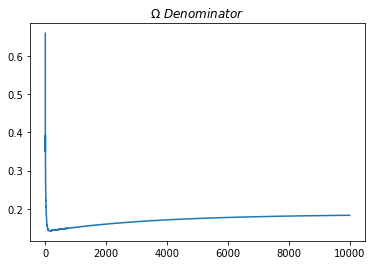

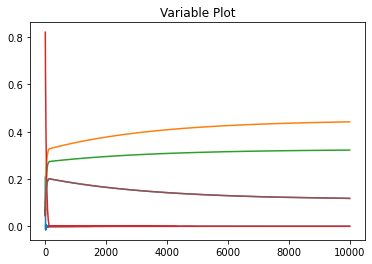

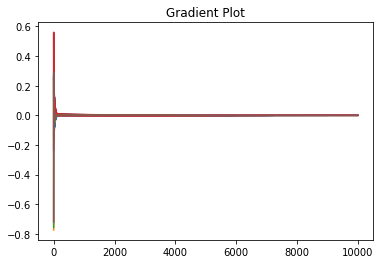

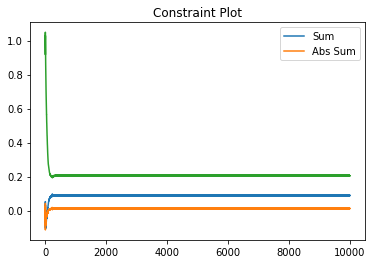

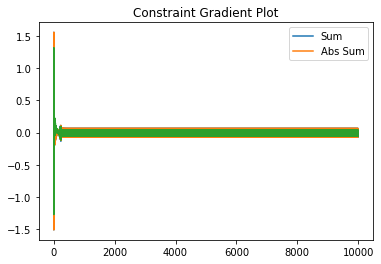

Optimal Portfolio:  [-2.45102476e-05  4.41900124e-01  3.22397557e-01 -1.18577039e-05
  1.17974752e-01  1.17974752e-01]
Portfolio Sum Sanity Check:  1.0002108177742646
Normalized Portfolio:  [-2.45050815e-05  4.41806983e-01  3.22329605e-01 -1.18552046e-05
  1.17949886e-01  1.17949886e-01]
Old Portfolio Omega(): -1.0152548744181875
Old Portfolio E[Z]:  0.331026780709241
New Portfolio Omega():  0.2688363615223668
New Portfolio E[Z]:  1.0492765413609677
Constraints:  [0.08919828 0.01285162 0.20514616]
Constraint Gradients:  [-0.0116013397443816, 0.0016887244762107123, -0.012579520467710381]


In [9]:
plt.plot(obj_history)
plt.title("$\Omega \ Denominator$")
plt.show()

plt.plot(var_history)
plt.title("Variable Plot")
plt.show()
plt.plot(grad_history)
plt.title("Gradient Plot")
plt.show()

plt.plot(c_history)
plt.title("Constraint Plot")
plt.legend(["Sum", "Abs Sum"])
plt.show()
plt.plot(cgrad_history)
plt.title("Constraint Gradient Plot")
plt.legend(["Sum", "Abs Sum"])
plt.show()
print("Optimal Portfolio: ", opt_var)
print("Portfolio Sum Sanity Check: ", np.sum(opt_var))
opt_var = opt_var/np.sum(opt_var)
print("Normalized Portfolio: ", opt_var)
print("Old Portfolio Omega():", omega(variables, E, tau=tau))
print("Old Portfolio E[Z]: ", np.dot(variables, E))

print("New Portfolio Omega(): ", omega(opt_var, E, tau=tau))
print("New Portfolio E[Z]: ", np.dot(opt_var, E))
print("Constraints: ", c_history[-1])
print("Constraint Gradients: ", cgrad_history[-1])

In [10]:
res = 1000
min_c = 0.0
max_c = 0.075

Expectation = []
Omega = []
Portfolios = []
for i in range(res):
    c_i = (max_c-min_c)*(i/(res-1)) + min_c
    variables = np.random.randn(len(x))
    tau=1.0
    variables = variables/np.sum(variables) #random distribution starting point
    constraints = [0.0, 0.0, 1.0]
    _, _, _, _, _, opt_var = h_gradient_descent(variables, 
                                                  np.array(E), 
                                                  constraints, 
                                                  lr=1e-1, 
                                                  steps=10000, 
                                                  tau=tau,
                                                  c=c_i)
    #print("C: ", c_i)
    opt_var = np.maximum(opt_var, 0)
    opt_var = opt_var/np.sum(opt_var)
    #print("Portfolio: ", opt_var)
    #print("E[Z]: ", np.dot(opt_var, E))
    #print("Omega: ", omega(opt_var, E, tau=tau))
    
    Expectation.append(np.dot(opt_var, E))
    Omega.append(omega(opt_var, E, tau=tau))
    Portfolios.append(opt_var)

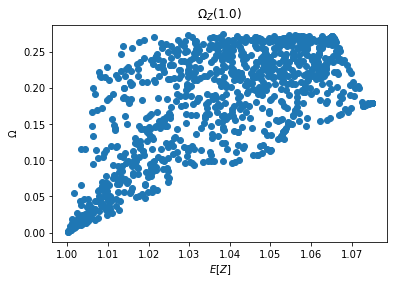

Portfolio:  [4.32797511e-06 3.43995934e-01 2.48284313e-01 5.97717556e-06
 7.09668467e-05 4.07638481e-01]


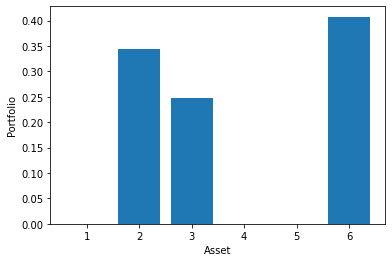

Omega:  0.27364078473016124
E[Z]:  1.038206917517294


In [11]:
plt.scatter(Expectation, Omega)
plt.title("$\Omega_{Z}(1.0)$")
plt.xlabel("$E[Z]$")
plt.ylabel("$\Omega$")
plt.show()

max_index = np.argmax(Omega)
max_omega = Omega[max_index]
max_port = Portfolios[max_index]
max_E = Expectation[max_index]

print("Portfolio: ", max_port)
plt.bar([1, 2, 3, 4, 5, 6], max_port)
plt.xlabel("Asset")
plt.ylabel("Portfolio")
plt.show()
print("Omega: ", max_omega)
print("E[Z]: ", max_E)